In [1]:
import os, sys
import matplotlib.pyplot as plt 
import seaborn
import matplotlib
import numpy as np 
import math 
import matplotlib
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


color_list = ['tab:orange',
            'tab:blue',
            'tab:green',
            'tab:red',
            'tab:purple',
            'tab:brown',
            'tab:pink',
            'tab:gray',
            'tab:olive',
            'tab:cyan']

hatch_list = [
    '', 
    '/', 
    '\\'
    '///', 
    '--', 
    '+', 
    'x'
    '*', 
    'o', 
    'O', 
    '.'
]

line_style_list = [
    '-', 
    '--', 
    '-.', 

]

marker_list = [
    '',
    'o', 
    'v',
    '^', 
    'X', 
    'D'
    's', 
]

template = {
    'fontsize': 18 + 4+4, 
    'linewidth': 6, 
    'scatter_markersize': 400, 
    'line_markersize': 20, 
    'width': 2, 
}

def autolabel_percent(rects, ax, value_list, error_list=None, str_func=None):
    if str_func is None: 
        str_func = lambda x: '%.2f'%(x)

    if error_list is None: 
        error_list = [0 for _ in value_list]

    for idx, rect in enumerate(rects):
        if value_list[idx] is None: continue
        height = rect.get_height()
        ax.annotate(str_func(value_list[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height+error_list[idx]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16, fontweight='bold')


def check_before_run(**kwargs): 
    if   kwargs['full'] + kwargs['half'] + kwargs['forth'] > 1: 
        return False 
    return True 


def apply_grid(ax, **kwargs): 
    if kwargs.get('grid'): 
        if not (kwargs.get('ygrid') or kwargs.get('xgrid')): 
            ax.grid(linestyle='-.', linewidth=1, alpha=0.5)

    if kwargs.get('ygrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='y')
    if kwargs.get('xgrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='x')


def apply_spine(ax, **kwargs): 
    if kwargs.get('spines'): 
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')


def apply_font(kwargs): 
    font = {'family' : 'serif',
            'size'   : 18}
    if kwargs.get('font'): 
        font.update(kwargs.get('font'))
    matplotlib.rc('font', **font)


def apply_log(ax, **kwargs): 
    if kwargs.get('logx'): 
        ax.set_xscale('log', basex=kwargs.get('logx'))
    if kwargs.get('logy') > 0: 
        ax.set_yscale('log', basey=kwargs.get('logy'))

def init_plot(ncols, **kwargs): 
    # if len(kwargs) > 0: 
    #     assert check_before_run(kwargs)
    
    apply_font(kwargs)
    if isinstance(ncols, tuple): 
        fig, axes = matplotlib.pyplot.subplots(ncols[0], ncols[1])
        fig.set_size_inches(w=ncols[1]* 4*3, h=3*ncols[0])
        
        axes = [axes[i] for i in range(ncols[0] * ncols[1])]
#         axes = [axes[j][i] for i in range(ncols[0]) for j in range(ncols[1])]
        # import pdb; pdb.set_trace() 
    else: 
        fig, axes = matplotlib.pyplot.subplots(1, ncols)
        if ncols == 1: 
            axes = [axes]
        fig.set_size_inches(w=ncols* 4, h=3)

    for ax in axes: 
        apply_grid(ax, **kwargs)
        apply_spine(ax, **kwargs)

    return fig, axes 


In [2]:
def cal_jct(df): 
    num_job = 1.0 * len(df)
    jct = 0
    min_time = sys.maxsize
    max_time = 0
    jct_list = list() 
    for idx, job in df.iterrows(): 
        jct += (job.completion_time - job.submission_time) / num_job
        min_time = min(job.submission_time, min_time)
        max_time = max(job.completion_time, max_time)
        jct_list.append((job.completion_time - job.submission_time))
    return jct, max(jct_list) # max_time - min_time

def cal_fft(df): 
    unfairs = 0 
    for idx, job in df.iterrows(): 
        if job.finish_time_fairness > 1: 
            unfairs += 1
    num_job = len(df)
    return unfairs / num_job

In [14]:
if True: 
    def transform(schedule): 
        if schedule == 'True': 
            return 'w/o LUT'
        else: 
            return 'w/ LUT'
    import glob 
    model_name_list = ['roberta-base', 'roberta-large', 'vit', 'vit-large']
    jct_info_by_method = list() # ('titan', '-True'), 
    makespan_info_by_method = list() 
    fairness_info_by_method = list() 
    for (schedule, sched_verbose) in [('False', ''), ('True', '')]:
        jct_list = list() 
        makespan_list = list() 
        fairness_list = list() 
        for model_id, model_name in enumerate(model_name_list):
            for trace_path in sorted(glob.glob('../trace/main/FM-*')): 
                if '-1-' not in trace_path: continue 
                if os.path.isdir(trace_path) and trace_path.endswith(model_name): 
                    trace_ident = os.path.basename(trace_path)
                    # if schedule == 'titan': 
                    trace_ident = trace_ident + sched_verbose
                    csv_name = os.path.join('../result/profile',  trace_ident, schedule, '{}.csv'.format('titan'))
                    df = pd.read_csv(csv_name)
                    jct, makespan = cal_jct(df)
                    jct_list.append(jct)
                    makespan_list.append(makespan)
                    csv_name = os.path.join('../result/profile',  trace_ident, schedule, '{}_fairness.csv'.format('titan'))
                    df = pd.read_csv(csv_name)
                    fft = cal_fft(df)
                    fairness_list.append(fft)
        sched_verbose = ''
        jct_info_by_method.append([transform(schedule) + sched_verbose, jct_list, [0 for jct in jct_list]])
        makespan_info_by_method.append([transform(schedule) + sched_verbose, makespan_list, [0 for makespan in makespan_list]])
        fairness_info_by_method.append([transform(schedule) + sched_verbose, fairness_list, [0 for makespan in makespan_list]])
            

In [15]:
def plot_bar_by_method(ax, info_by_method, **kwargs): 
    apply_log(ax, **kwargs)
    width = kwargs.get('width', 0.3)
    interval = int(math.ceil(width * len(info_by_method)) * 2)
    if kwargs.get('norm'): 
        norm_list = list() 
    
    for idx, (ident, y_list, error_list) in enumerate(info_by_method): 
        x_list = list() 
        base = width * ( (len(info_by_method) - 1) // 2 + 0.5 * (len(info_by_method) - 1) % 2 ) + idx * width
        value_list = list() 
        for idy, y in enumerate(y_list): 
            x_list.append(base + idy * interval)
            value_list.append(y)


        if kwargs.get('norm'): 
            if len(norm_list) > 0: 
                print(ident)
                print(norm_list, len(norm_list))
                print(value_list, len(value_list))
            if len(norm_list) == 0: 
                norm_list = [val for val in value_list]
                value_list = [1. for _ in value_list]
            else: 
                value_list = [val / norm for val, norm in zip(value_list, norm_list)]
                # import pdb; pdb.set_trace() 
        # import pdb; pdb.set_trace() 
        if error_list is None: 
            error_list = [0 for _ in y_list]
        
        def cap(value): 
            return value 
            # if value < 5: 
            #     return value 
            # else: 
            #     return 5 + (value - 5) / 5
        value_list = [cap(value) for value in  value_list]
        if kwargs.get('disable_legend'): 
            rect = ax.bar(x_list, value_list, yerr=error_list, width=width, color=color_list[idx], hatch=hatch_list[idx], alpha=0.75, edgecolor='black', capsize=0)
        else: 
            rect = ax.bar(x_list, value_list, yerr=error_list, width=width, color=color_list[idx], hatch=hatch_list[idx], alpha=0.75, edgecolor='black', capsize=0, label=ident)
        
        print('x_list', x_list)
        print('y_list', y_list)
        if kwargs.get('autolabel'): 
            #autolabel_percent(rects, ax, value_list, error_list=None, str_func=None):
            str_func = None 
            if kwargs.get('norm'): 
                str_func = lambda x: '%.2f'%(x)
            elif 'int' in str(type(y_list[0])):
                str_func = lambda x: '%d'%(x)
            print('value_list {}'.format(value_list))
            # autolabel_percent(rect, ax, value_list, error_list=error_list, str_func=str_func)
        ax.set_xticks([])
        ax.set_xticks([], minor=True)


# JCT

In [16]:
jct_info_by_method

[['w/ LUT',
  [510.8309395432466,
   529.8327310959503,
   815.2706789106134,
   1006.7080175086861],
  [0, 0, 0, 0]],
 ['w/o LUT',
  [669.4912359714496,
   883.8918096780785,
   911.6253856644036,
   1002.9972082674504],
  [0, 0, 0, 0]]]

1
x_list [0.15, 2.15, 4.15, 6.15]
y_list [510.8309395432466, 529.8327310959503, 815.2706789106134, 1006.7080175086861]
w/o LUT
[510.8309395432466, 529.8327310959503, 815.2706789106134, 1006.7080175086861] 4
[669.4912359714496, 883.8918096780785, 911.6253856644036, 1002.9972082674504] 4
x_list [0.44999999999999996, 2.45, 4.45, 6.45]
y_list [669.4912359714496, 883.8918096780785, 911.6253856644036, 1002.9972082674504]


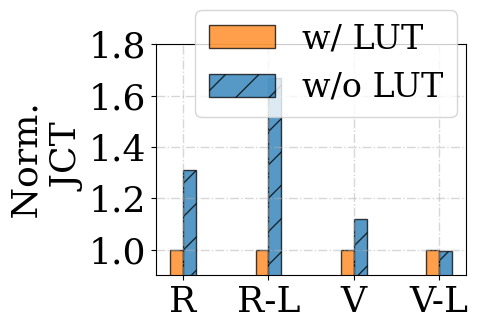

In [18]:
fig, axes = init_plot(1, grid=True)
print(len(axes))
# jct 
if True: 
#     model_name_list = ['Roberta', 'Roberta-L', 'ViT', 'ViT-L']
    new_template =  {
        "norm": False, 
        "width": 0.3, 
        "autolabel": False, 
        'norm': True,
        'logy': -1,
        'yname': True if model_id == 0 else None, 
        'disable_legend': False,
        'xname': None,
    }
    x_list = [i for i in range(10)]
    y_list = [np.random.randn(1) for x in x_list]
    template.update(new_template)

    ax = axes[0]
    plot_bar_by_method(ax, jct_info_by_method, **template)
    ax.set_ylabel(' Norm. \n JCT', fontsize=template['fontsize'])
    ax.set_yticks([1, 1.2, 1.4, 1.6, 1.8])
    ax.set_ylim(0.9, 1.8)
    ax.tick_params(axis='both', labelsize=template['fontsize'])

        

    xlabel_list = ['R', 'R-L', 'V', 'V-L']
    new_template =  {
        "norm": False, 
        "width": 0.3, 
        "autolabel": False, 
        'norm': True,
        'logy': 0,
        'disable_legend': True,
        'yname': True if model_id == 0 else None, 
        'xname': model_name,
    }
    
axes_list = [0.44999999999999996, 2.45, 4.45, 6.45]
if True: 
    ax.set_xticks([val - 0.15 for val in axes_list])
    ax.set_xticklabels(xlabel_list, fontsize=template['fontsize'], rotation=0)
fig.legend(fontsize=template['fontsize'] - 2, loc='upper center', ncol=1, bbox_to_anchor=(0.55, 1.05), fancybox=True, shadow=False) 
# plt.savefig('images/heter/jct.jpg', bbox_inches='tight')
plt.savefig('images/profile/jct.pdf', bbox_inches='tight')
plt.show()

